# PyCC Sequential Learning Tutorial

*Authors: Edward Kim, Enze Chen*

In this notebook, we will cover how to perform **sequential learning** (SL) using the [Citrination API](http://citrineinformatics.github.io/python-citrination-client/). [Sequential learning](https://citrine.io/platform/sequential-learning/) is the key workflow which allows machine learning algorithms and in-lab experiments to iteratively inform each other.

To replace the need for an actual laboratory, this notebook uses a simple *toy function* that allows for "measurements" on the data.

## Learning objectives

By the end of this tutorial, you will know how to:

- Use PyCC end to end, from uploading an initial dataset to running SL
- Understand how to configure SL parameters to match your laboratory setup
- Asynchronously issue SL jobs to Citrination's backend

## Background knowledge

In order to get the most out of this tutorial, you should already be familiar with the following:

- Create and access datasets through the API ([tutorial](https://github.com/CitrineInformatics/community-tools/blob/master/api_examples/data_client_api_tutorial.ipynb))
- Create and access data views through the API ([tutorial](https://github.com/CitrineInformatics/community-tools/blob/master/api_examples/data_views_api_tutorial.ipynb))
- What the data views [front-end UI](https://citrination.com/data_views) looks like, particularly the Design interface

## BEFORE YOU RUN THIS NOTEBOOK

This notebook uses some convenience functions to wrap several API endpoints. These are listed at the end of the notebook in the section titled [**Convenience functions**](#Convenience-functions-(Run-these-first!)). Run those functions first before running the main notebook!

## Imports

In [7]:
# Standard packages
from os import environ
from time import sleep

# Third-party packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pypif import pif
from pypif.obj import *
from citrination_client import CitrinationClient
from citrination_client.models.design import Target

sns.set_context("talk")
sns.set_style("whitegrid")

## Setting up a client

Make sure to properly set your **environment variable** to hold your API key.

In [8]:
client = CitrinationClient(
    environ.get("CITRINATION_API_KEY_PUBLIC"),
    "https://citrination.com"
)

## Data generation

Since we aren't using a real laboratory, we need access to a quick way to generate "correct" measurements. A simple placeholder here is to use a function that sums the squares of its inputs. The goal, in this case, will be to find the global minimum located at the origin. 

In a real example, we could minimize or maximize any output: compressive strengths, conductivities, and so on.

In [20]:
def toy_func(inputs):
    func_sum = 0.0
    for inp in inputs:
        func_sum += inp**2
    return func_sum

toy_x = [np.random.normal(loc=2.0, scale=1.0, size=(1, 2))[0] for x in range(20)]
toy_y = [toy_func(x) for x in toy_x]

initial_best_measured_value = min(toy_y)

print(f"Best (lowest) value in initial training set: {initial_best_measured_value}")

Best (lowest) value in initial training set: 1.333412256525806


Now we can plot the initial training set, and color it by the function value.

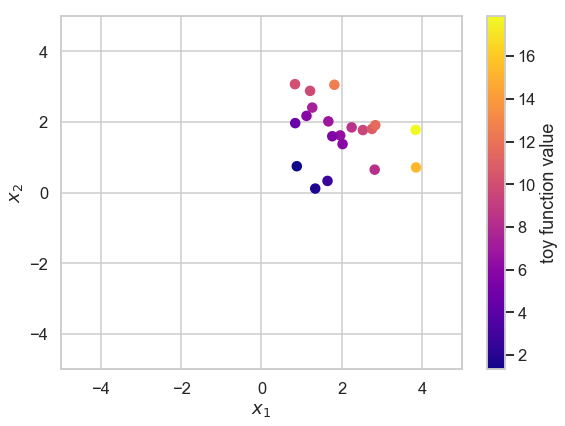

In [53]:
# Plot initial training set, colored by toy function values

plt.rcParams['figure.figsize'] = (9,6.5)
plt.scatter(np.array(toy_x)[:,0], np.array(toy_x)[:,1],
            c=toy_y, cmap=plt.cm.plasma)
plt.colorbar(label='toy function value')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.show()

In [23]:
# Write a PIF JSON dataset file
write_dataset_from_func(toy_func, "toy_initial_dataset.json", toy_x)

In [24]:
# Make a dataset, upload to Citrination, return/print the ID

dataset_id = upload_data_and_get_id(
    client,
    "toy_initial_dataset",
    "toy_initial_dataset.json",
    create_new_version=True,
#   given_dataset_id=1234
)
print(f"Dataset created: {dataset_id}")

Dataset created: 174174


In [25]:
# Make a data view on Citrination, return/print the ID

view_id = build_view_and_get_id(client, dataset_id, "toy_view", view_desc="toy test view",
                      input_keys=["Property x1", "Property x2"], output_keys=["Property y"])

print(f"Data view created: {view_id}")

Data view created: 8378


If this is not your first time running this notebook, you can change the following variables to match what you've already created.

In [17]:
# dataset_id = 123456
# view_id = 1234

# Running design

Now we call a function that runs the SL process. In short, we run a loop where we do the following:

1. Submit a design run (and poll status w/ wait times)
1. Get best candidates and record predicted results
1. Measure candidates (using toy function evaluation) and record measured results
1. Add candidates to dataset
1. Retrain on dataset (and poll status w/ wait times)
1. Repeat until max iterations reached

Detailed comments can be found in the [function docstring](#run_sequential_learning).

In [26]:
sl_results = {}

best_sl_pred_vals, best_sl_measured_vals = run_sequential_learning(
    client=client,
    view_id=str(view_id),
    dataset_id=str(dataset_id),
    num_candidates_per_iter=10,
    design_effort=20,
    wait_time=5,
    num_sl_iterations=5,
    input_properties=["Property x1", "Property x2"],
    target=["Property y", "Min"],
    print_output=True,
    true_function=toy_func,
    score_type="MLI"
)

# Reset dataset after each SL run
dataset_id = upload_data_and_get_id(
    client,
    "toy_initial_dataset",
    "toy_initial_dataset.json",
    create_new_version=True,
    given_dataset_id=dataset_id
)

sl_results["predicted"] = best_sl_pred_vals
sl_results["measured"] = best_sl_measured_vals


---STARTING SL ITERATION #1---
Design ready
Created design run with ID 48f43f61-eb86-4e2b-99ac-b5ad236b1527
Design run status: Accepted
Design run status: Accepted
Design run status: Accepted
Design run status: Processing
Design run status: Processing
Design run status: Processing
Design run status: Finished
SL iter #1, best predicted (value, uncertainty) = ('10.821031435896407', '0.0')
Dataset updated: 10 candidates added
New dataset contains 30 PIFs
Design ready

---STARTING SL ITERATION #2---
Design ready
Created design run with ID 65d2b0ea-d220-4491-b717-b8016051d6e0
Design run status: Accepted
Design run status: Processing
Design run status: Processing
Design run status: Processing
Design run status: Finished
SL iter #2, best predicted (value, uncertainty) = ('1.58', '0.76')
Dataset updated: 10 candidates added
New dataset contains 38 PIFs
Design ready

---STARTING SL ITERATION #3---
Design ready
Created design run with ID 7bc15832-1a0c-4717-ab4a-ad916d6cc829
Design run status: A

## Examining the results

Finally, we can plot the results: Here, we are plotting the best measured candidate against the number of SL iterations. In this case, lower = better for the measured results (since we are doing function minimization).

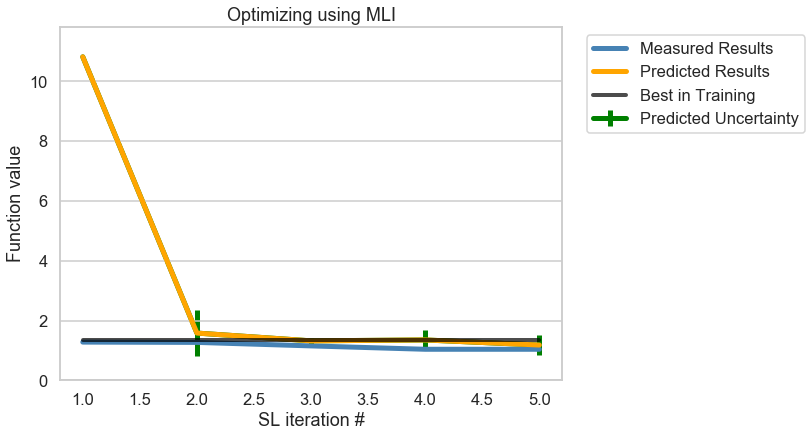

In [54]:
# Measured results
sns.lineplot(
    x=np.arange(1, len(sl_results["measured"])+1),
    y=[round(float(v), 3) for v in sl_results["measured"]],
    lw=5,
    estimator=None,
    markers=True,
    color="steelblue",
    label=f"Measured Results",
    legend=False,

)

# Predicted results
predicted_ax = sns.lineplot(
    x=np.arange(1, len(sl_results["predicted"])+1),
    y=[round(float(v[0]), 3) for v in sl_results["predicted"]],
    lw=5,
    estimator=None,
    markers=True,
    color="orange",
    label=f"Predicted Results",
    legend=False,

)

# Error bars
predicted_ax.errorbar(
    np.arange(1, len(sl_results["predicted"])+1), 
    [round(float(v[0]), 3) for v in sl_results["predicted"]], 
    yerr=[round(float(v[1]), 3) for v in sl_results["predicted"]],
    lw=5,
    color="green",
    ecolor=["green"]*5,
    label="Predicted Uncertainty",
    fmt='', 
    zorder=-1
)

# Best candidate in training set
sns.lineplot(
    x=np.arange(1, 6),
    y=[initial_best_measured_value]*5,
    estimator=None,
    markers=False,
    label=f"Best in Training",
    legend=False,
    color="black",
    lw=4,
    alpha=0.7
)


plt.xlabel("SL iteration #")
plt.legend(loc='best', bbox_to_anchor=(1.5, 1.0))
plt.ylabel("Function value")
plt.ylim([0,float(sl_results['predicted'][0][0])+1])
plt.title(f"Optimizing using MLI")
plt.grid(b=False, axis='x')
plt.show()

## Conclusion
To recap, this notebook went through the steps for running SL using the API.
1. First, we created and uploaded an initial dataset.
1. Then, we created a data view and trained the model.
1. We ran the SL process, measuring and updating new candidates after each iteration.
1. Finally we examined our SL results.

## Additional resources
It's now possible to conduct the major aspects of the Citrination workflow through the API, which should increase the speed and flexibility of informatics approaches. Some other topics that might interest you include:
* [DataClient](http://citrineinformatics.github.io/python-citrination-client/tutorial/data_examples.html) - This allows you to create datasets and upload PIF data (only) using the API.
  * There is also a corresponding [tutorial](https://github.com/CitrineInformatics/community-tools/blob/master/api_examples/data_client_api_tutorial.ipynb).

* [DataViewsClient](https://github.com/CitrineInformatics/python-citrination-client/tree/develop/citrination_client/views) - This allows you to build views (i.e. train ML models) using the API.
  * There is also a corresponding [tutorial](data_views_api_tutorial.ipynb).

## Convenience functions (Run these first!)

In [1]:
# Extra imports for convenience functions

import json
from collections import OrderedDict
from time import sleep
from typing import Callable, List, Tuple, Optional

import numpy as np
from citrination_client import (CitrinationClient, DataQuery, DatasetQuery,
                                Filter, PifSystemReturningQuery,
                                RealDescriptor)
from citrination_client.models.design import Target
from citrination_client.views.data_view_builder import DataViewBuilder
from pypif import pif
from pypif.obj import *

### `write_dataset_from_func`

In [2]:
def write_dataset_from_func(test_function:Callable[[np.ndarray], float],
                        filename:str, input_vals:List[np.ndarray]) -> None:
    '''Given a function, write a dataset evaluated on given input values
    
    :param test_function: Function for generating dataset
    :type test_function: Callable[[np.ndarray], float]
    :param filename: Name of file for saving CSV dataset
    :type filename: str
    :param input_vals: List of input values to eval function over
    :type input_vals: np.ndarray
    :return: Doesn't return anything
    :rtype: None
    '''

    pif_systems = []    
    for i, val_row in enumerate(input_vals):
        system = System()
        system.names = f'{test_function.__name__}_{i}' 
        system.properties =  []

        for j, x_val in enumerate(val_row):
            func_input = Property()
            func_input.name = f"x{j+1}"
            func_input.scalars = x_val
            system.properties.append(func_input)

        func_output = Property()
        func_output.name = f"y"
        func_output.scalars = test_function(val_row)
        system.properties.append(func_output)
        pif_systems.append(system)

    with open(filename, "w") as f:
        f.write(pif.dumps(pif_systems, indent=4))

### `upload_data_and_get_id`

In [3]:
def upload_data_and_get_id(client:CitrinationClient,
                        dataset_name:str,
                        dataset_local_fpath:str,
                        create_new_version:Optional[bool] = False,
                        given_dataset_id:Optional[int] = None) -> int:
    '''Uploads data to a new/given dataset and returns its ID
    
    :param client: Client API object to pass in
    :type client: CitrinationClient
    :param dataset_name: Name of dataset
    :type dataset_name: str
    :param dataset_local_fpath: Local data filepath
    :type dataset_local_fpath: str
    :param create_new_version: Whether or not to make a new version
    :param create_new_version: bool
    :param given_dataset_id: ID if using existing dataset, defaults to None
    :param given_dataset_id: int
    :return: ID of the dataset
    :rtype: int
    '''


    if given_dataset_id is None:
        dataset = client.data.create_dataset(dataset_name)
        dataset_id = dataset.id
    else:   
        dataset_id = given_dataset_id
        if create_new_version:
            client.data.create_dataset_version(dataset_id)

    client.data.upload(dataset_id, dataset_local_fpath)
    assert (client.data.matched_file_count(dataset_id) >= 1), "Upload failed."
    return dataset_id

### `build_view_and_get_id`

In [4]:
def build_view_and_get_id(client:CitrinationClient, dataset_id:int,
                        view_name:str, input_keys:List[str], 
                        output_keys:List[str], view_desc:str = "",
                        wait_time:int = 2, print_output:bool = False) -> int:
    '''Builds a new data view and returns the view ID
    
    :param client: Client object
    :type client: CitrinationClient
    :param dataset_id: Dataset to build view from
    :type dataset_id: int
    :param view_name: Name of the new view
    :type view_name: str
    :param input_keys: Input key names
    :type input_keys: List[str]
    :param output_keys: Output key names
    :type output_keys: List[str]
    :param view_desc: Description for the view, defaults to ""
    :param view_desc: str, optional
    :param wait_time: Wait time in seconds before polling API
    :type wait_time: int
    :param print_output: Whether or not to print outputs
    :type print_output: bool
    :return: ID of the view
    :rtype: int
    '''

    dv_builder = DataViewBuilder()
    dv_builder.dataset_ids([str(dataset_id)])
    dv_builder.model_type('default') # random forest

    for key_name in input_keys:
        desc_x = RealDescriptor(key=key_name)
        dv_builder.add_descriptor(desc_x, role='input')

    for key_name in output_keys:
        desc_y = RealDescriptor(key=key_name)
        dv_builder.add_descriptor(desc_y, role='output')

    dv_config = dv_builder.build()

    _wait_on_ingest(client, dataset_id, wait_time, print_output)

    dv_id = client.data_views.create(
        dv_config, 
        name=view_name, 
        description=view_desc
    )
    return dv_id

### `run_sequential_learning`

In [5]:
def run_sequential_learning(client:CitrinationClient, view_id:int, dataset_id:int,
                        num_candidates_per_iter:int,
                        design_effort:int, wait_time:int, 
                        num_sl_iterations:int, input_properties:List[str],
                        target:List[str], print_output:bool,
                        true_function:Callable[[np.ndarray], float],
                        score_type:str,
                        ) -> Tuple[List[float], List[float]]:
    '''Runs SL design
    
    :param client: Client object
    :type client: CitrinationClient
    :param view_id: View ID
    :type view_id: int
    :param dataset_id: Dataset ID
    :type dataset_id: int
    :param num_candidates_per_iter: Candidates in a batch
    :type num_candidates_per_iter: int
    :param design_effort: Effort from 1-30
    :type design_effort: int
    :param wait_time: Wait time in seconds before polling API
    :type wait_time: int
    :param num_sl_iterations: SL iterations to run
    :type num_sl_iterations: int
    :param input_properties: Inputs
    :type input_properties: List[str]
    :param target: ("Output property", {"Min", "Max"})
    :type target: List[str]
    :param print_output: Whether or not to print outputs
    :type print_output: bool
    :param true_function: Actual function for evaluating measured/true values
    :type true_function: Callable[[np.ndarray], float]
    :param score_type: MLI or MEI
    :type score_type: str
    :return: 2-tuple: list of predicted scores/uncertainties; list of measured scores/uncertainties
    :rtype: Tuple[List[float], List[float]]
    '''



    best_sl_pred_vals = []
    best_sl_measured_vals = []

    _wait_on_ingest(client, dataset_id, wait_time, print_output)

    for i in range(num_sl_iterations):
        if print_output:
            print(f"\n---STARTING SL ITERATION #{i+1}---")

        _wait_on_ingest(client, dataset_id, wait_time, print_output)
        _wait_on_data_view(client, dataset_id, view_id, wait_time, print_output)
            
        # Submit a design run
        design_id = client.submit_design_run(
                data_view_id=view_id,
                num_candidates=num_candidates_per_iter, 
                effort=design_effort, 
                target=Target(*target), 
                constraints=[], 
                sampler="Default"
            ).uuid
        
        if print_output:
            print(f"Created design run with ID {design_id}")

        _wait_on_design_run(client, design_id, view_id, wait_time, print_output)

        # Compute the best values with uncertainties as a list of (value, uncertainty)
        if score_type == "MEI":
            candidates = client.get_design_run_results(view_id, design_id).best_materials
        else:
            candidates = client.get_design_run_results(view_id, design_id).next_experiments
        values_w_uncertainties = [
            (
                m["descriptor_values"][target[0]], 
                m["descriptor_values"][f"Uncertainty in {target[0]}"]
            ) for m in candidates
        ]

        # Find and save the best predicted value
        if target[1] == "Min":
            best_value_w_uncertainty = min(values_w_uncertainties, key=lambda x: x[0])
        else:
            best_value_w_uncertainty = max(values_w_uncertainties, key=lambda x: x[0])

        best_sl_pred_vals.append(best_value_w_uncertainty)
        if print_output: 
            print(f"SL iter #{i+1}, best predicted (value, uncertainty) = {best_value_w_uncertainty}")
            
        # Update dataset w/ new candidates
        new_x_vals = []
        for material in candidates:
            new_x_vals.append(np.array(
                [float(material["descriptor_values"][x]) for x in input_properties]
            ))
        
        temp_dataset_fpath = f"design-{design_id}.json"
        write_dataset_from_func(true_function, temp_dataset_fpath, new_x_vals)
        upload_data_and_get_id(
            client,
            "", # No name needed for updating a dataset
            temp_dataset_fpath,
            given_dataset_id=dataset_id
        )

        _wait_on_ingest(client, dataset_id, wait_time, print_output)
        
        if print_output:
            print(f"Dataset updated: {len(new_x_vals)} candidates added")
            
        query_dataset = PifSystemReturningQuery(size=9999, 
                            query=DataQuery(
                            dataset=DatasetQuery(
                                id=Filter(equal=str(dataset_id))
                        )))
        query_result = client.search.pif_search(query_dataset)      

        if print_output:
            print(f"New dataset contains {query_result.total_num_hits} PIFs")
        
        # Update measured values in new dataset
        dataset_y_values = []
        for hit in query_result.hits:
            # Assume last prop is output if following this script
            dataset_y_values.append(
                float(hit.system.properties[-1].scalars[0].value)
            )
        
        if target[1] == "Min":
            best_sl_measured_vals.append(min(dataset_y_values))
        else:
            best_sl_measured_vals.append(max(dataset_y_values))
                            
        # Retrain model w/ wait times
        client.data_views.retrain(view_id)
        _wait_on_data_view(client, dataset_id, view_id, wait_time, print_output)
    
    if print_output:
        print("SL finished!\n")
    
    return (best_sl_pred_vals, best_sl_measured_vals)  

### More helper functions

In [6]:
def _wait_on_ingest(client:CitrinationClient, dataset_id:int, 
                        wait_time:int, print_output:bool=True) -> None:
    # Wait for ingest to finish
    sleep(wait_time)
    while (client.data.get_ingest_status(dataset_id) != "Finished"):
        if print_output:
            print("Waiting for data ingest to complete...")
        sleep(wait_time)

def _wait_on_data_view(client:CitrinationClient, dataset_id:int, 
                        view_id:int, wait_time:int, 
                        print_output:bool=True) -> None:
    is_view_ready = False
    sleep(wait_time)
    while (not is_view_ready):
        sleep(wait_time)
        design_status = client.data_views.get_data_view_service_status(view_id)
        if (design_status.experimental_design.ready and 
        design_status.predict.event.normalized_progress == 1.0):
            is_view_ready = True
            if print_output:
                print("Design ready")
        else:
            print("Waiting for design services...")

def _wait_on_design_run(client:CitrinationClient, design_id:int, view_id:int,
                        wait_time:int, print_output:bool=True) -> None:
    design_processing = True
    sleep(wait_time)
    while design_processing:
        status = client.get_design_run_status(view_id, design_id).status
        if print_output: 
            print(f"Design run status: {status}")
            
        if status != "Finished":
            sleep(wait_time)
        else:
            design_processing = False

### [Return to top](#Imports)